# Analysis of FBI Supplemental Homicide Report Data 

In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
from utils import nb_run_from_command


## Data Import

In [2]:
# step backwards if notebook is being run interactively
# or stay put if being run from command line
if nb_run_from_command():
    os.chdir("..")


In [3]:
read_sql = lambda query, con: pd.read_sql(query, con).replace({"": np.NaN, "U": np.NaN})

with sqlite3.connect("input/sqlite__temp.db") as con:
    incidents = read_sql(
        """
        SELECT * FROM data_shrincidents;
        """,
        con,
    )
    offenders = read_sql(
        """
        SELECT * FROM data_shroffenders;
        """,
        con,
    )
    victims = read_sql(
        """
        SELECT * FROM data_shrvictims;
        """,
        con,
    )
    agencies = read_sql(
        """
        SELECT * FROM data_agencies;
        """,
        con,
    )


### Data Preparation

In [4]:
# standard columns used to reduce offender and victim data to one row per incident
GB_COLS = ["incident_id", "ori_code", "year"]


Get a dataframe containing one row per incident and columns indicating which offender information was reported

In [5]:
gb = offenders.groupby(GB_COLS)

join_args = {"how": "left"}

get_offender_info = lambda field: (
    gb[field]
    .apply(lambda vals: any(pd.notna(a) for a in vals))
    .to_frame(f"{field}_reported")
)

offender_info = (
    get_offender_info("offender_age")
    .join(get_offender_info("offender_sex"), **join_args)
    .join(get_offender_info("offender_race"), **join_args)
    .assign(any_offender_info=lambda df: df.any(axis=1))
    .assign(all_offender_info=lambda df: df.all(axis=1))
)

offender_info


,,,offender_age_reported,offender_sex_reported,offender_race_reported,any_offender_info,all_offender_info
incident_id,ori_code,year,,,,,
00001dd6fa45f7ba044bd5d84937be464ce78ac2,PAPEP0000,1995,True,True,True,True,True
0000296564272665ccd2925d377e124f3306b01e,INIPD0000,2004,False,False,False,False,False
000055d41c8a62052dd426592e8a4a3342bf565d,TX2260100,2020,True,True,True,True,True
0000b76d2145d9445d9ff6b65c9ebc4196c89337,GAAPD0000,2007,False,False,False,False,False
00010f65a5340264303727655cc554fdfd0da8f2,PA0022800,2001,True,True,True,True,True
...,...,...,...,...,...,...,...
fffe9c57a9b25623ac219260c1b5155087a788e9,TN0750100,2009,True,True,True,True,True
fffee86a5a0ce70dab14272b3924c41074fb1c61,GA0630100,2008,False,False,False,False,False
fffee88a3e3859d763c7b8f527745155abbb54ac,NY0303000,2011,False,False,False,False,False


Get a dataframe containing one row per incident with victim demographic data included

In [6]:
victims.victim_race.unique()


array(['B', 'W', 'A', 'I', nan, 'P'], dtype=object)

In [7]:
victims.victim_ethnicity.unique()


array([nan, 'H', 'N'], dtype=object)

In [8]:
victim_info = (
    victims.groupby(GB_COLS)
    .apply(
        lambda group: "hispanic only"
        if all(v == "H" for v in group.victim_ethnicity)
        else "white only"
        if all(v == "W" for v in group.victim_race)
        else "black only"
        if all(v == "B" for v in group.victim_race)
        else "mixed white and black"
        if any(v == "W" for v in group.victim_race)
        and any(v == "B" for v in group.victim_race)
        else "other"
        if all(v in ["A", "I", "P"] for v in group.victim_race)
        else "two or more races" if len(list(set(group.victim_race))) > 1
        else "unknown/no race data"
    )
    .to_frame("race_category")
)

victim_info


,,,race_category
incident_id,ori_code,year,
00001dd6fa45f7ba044bd5d84937be464ce78ac2,PAPEP0000,1995,black only
0000296564272665ccd2925d377e124f3306b01e,INIPD0000,2004,white only
000055d41c8a62052dd426592e8a4a3342bf565d,TX2260100,2020,hispanic only
0000b76d2145d9445d9ff6b65c9ebc4196c89337,GAAPD0000,2007,black only
00010f65a5340264303727655cc554fdfd0da8f2,PA0022800,2001,white only
...,...,...,...
fffe9c57a9b25623ac219260c1b5155087a788e9,TN0750100,2009,black only
fffee86a5a0ce70dab14272b3924c41074fb1c61,GA0630100,2008,white only
fffee88a3e3859d763c7b8f527745155abbb54ac,NY0303000,2011,black only


### Availability of offender demographic information

In [9]:
def get_demo_crosstab(field):
    def to_multiindex(df):
        df.columns = pd.MultiIndex.from_tuples([(field, c) for c in df.columns])
        return df

    return (
        pd.crosstab(
            index=offender_info.index.get_level_values("year"),
            columns=[
                offender_info[field],
            ],
        )
        .assign(pct_reported=lambda df: df[True] / (df[False] + df[True]))
        .pipe(to_multiindex)
    )


(
    get_demo_crosstab("offender_sex_reported")
    .join(get_demo_crosstab("offender_race_reported"))
    .join(get_demo_crosstab("offender_age_reported"))
    .join(get_demo_crosstab("any_offender_info"))
    .join(get_demo_crosstab("all_offender_info"))
)


offender_sex_reported                     offender_race_reported         \
                      False   True pct_reported                  False   True   
row_0                                                                           
1995                   6501  13598     0.676551                   6707  13392   
1996                   5342  11712     0.686760                   5488  11566   
1997                   5117  10812     0.678762                   5263  10666   
1998                   4315   9998     0.698526                   4448   9865   
1999                   3973   9013     0.694055                   4103   8883   
2000                   4093   9127     0.690393                   4200   9020   
2001                   4307   9839     0.695532                   4528   9618   
2002                   4420   9832     0.689868                   4562   9690   
2003                   4643   9778     0.678039                   4772   9649   
2004                   4495   9788     0.685290                   4615   9668   
2005                   4565  10309     0.693089                   4741  10133   
2006                   4637  10439     0.692425                   4768  10308   
2007                   4785  10192     0.680510                   4932  10045   
2008                   4459   9877     0.688965                   4610   9726   
2009                   4091   9767     0.704791                   4211   9647   
2010                   3952   9348     0.702857                   4087   9213   
2011                   3829   9058     0.702879                   3941   8946   
2012                   3978   9090     0.695592                   4086   8982   
2013                   3834   8712     0.694405                   3935   8611   
2014                   3841   8691     0.693505                   3951   8581   
2015                   4459   9385     0.677911                   4591   9253   
2016                   5198  10133     0.660948                   5364   9967   
2017                   4953  10721     0.683999                   5135  10539   
2018                   4422  10502     0.703699                   4594  10330   
2019                   4387  10207     0.699397                   4582  10012   
2020                   5929  12535     0.678889                   6183  12281   

                   offender_age_reported                      \
      pct_reported                 False   True pct_reported   
row_0                                                          
1995      0.666302                  7482  12617     0.627743   
1996      0.678199                  6157  10897     0.638970   
1997      0.669596                  5909  10020     0.629041   
1998      0.689234                  5061   9252     0.646405   
1999      0.684044                  4625   8361     0.643847   
2000      0.682300                  4797   8423     0.637141   
2001      0.679910                  5176   8970     0.634102   
2002      0.679905                  5208   9044     0.634578   
2003      0.669094                  5539   8882     0.615907   
2004      0.676889                  5310   8973     0.628229   
2005      0.681256                  5325   9549     0.641993   
2006      0.683736                  5324   9752     0.646856   
2007      0.670695                  5445   9532     0.636443   
2008      0.678432                  5041   9295     0.648368   
2009      0.696132                  4645   9213     0.664815   
2010      0.692707                  4467   8833     0.664135   
2011      0.694188                  4354   8533     0.662140   
2012      0.687328                  4489   8579     0.656489   
2013      0.686354                  4266   8280     0.659971   
2014      0.684727                  4152   8380     0.668688   
2015      0.668376                  4847   8997     0.649884   
2016      0.650121                  5597   9734     0.634923   
2017      0.672387                  5338  10336     0.65

In [10]:
# single dataframe from which we'll do all analysis
df = (
    incidents.rename(columns={"incident_unique_id": "incident_id"})
    .set_index(GB_COLS)
    .join(offender_info)
    .join(victim_info)
    .reset_index()
)

df


,incident_id,ori_code,year,last_update,homicide,situation,offender_age_reported,offender_sex_reported,offender_race_reported,any_offender_info,all_offender_info,race_category
0,b6589fc6ab0dc82cf12099d1c2d40ab994e8410c,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
1,356a192b7913b04c54574d18c28d46e6395428ab,AK0010100,2020,2021-09-30,A,C,True,True,True,True,True,black only
2,da4b9237bacccdf19c0760cab7aec4a8359010b0,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,white only
3,77de68daecd823babbb58edb1c8e14d7106e83bb,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
4,1b6453892473a467d07372d45eb05abc2031647a,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
...,...,...,...,...,...,...,...,...,...,...,...,...
380983,27f057b7644a9e3a59e579325d91dd5be2b8406a,HI0040000,2005,2005-07-25,A,A,True,True,True,True,True,white only
380984,ae0906ac7c4d9a67e29455bc1f16bac9a05bfcbd,HI0040000,2005,2005-08-17,A,A,True,True,True,True,True,white only
380985,ea8990941c60eb553983d700ad9d41bebd7283e0,HI0050000,2005,2005-08-05,A,B,False,False,False,False,False,black only
380986,1bb31a3533794756fc6cb271898a9ce93526f256,HI0050000,2005,2005-09-22,A,A,True,True,True,True,True,white only


## Analysis

### National

Nationally, the rate of offender demographics reported is substantially lower for homicides with Black victims than it is with white victims. In 2020, less than 60% of cases with only Black victims had offender demographic data present, compared to bout 80% for white victims. Cases with both Black and White victims had offender demographic information bout 72% of the time. 

In [11]:
def get_demo_pcts(df):
    for race in df.columns.get_level_values("race_category"):
        df[(race, "offender_info_reported")] = df[(race, True)] / (
            df[(race, False)] + df[(race, True)]
        )

    df = df[[c for c in df.columns if c[1] == "offender_info_reported"]]
    df.columns = df.columns.droplevel(1)
    return df


national = pd.crosstab(
    index=df.year, columns=[df.race_category, df.any_offender_info]
).pipe(get_demo_pcts)

national.to_csv("output/shr_national.csv")

national


race_category,black only,hispanic only,mixed white and black,other,two or more races,unknown/no race data,white only
year,,,,,,,
1995,0.641845,0.623921,0.714286,0.720000,0.733333,0.445026,0.743692
1996,0.648429,0.653769,0.631579,0.726852,0.833333,0.443709,0.752424
1997,0.637750,0.613303,0.653846,0.714943,0.545455,0.461538,0.759972
1998,0.653714,0.654469,0.575758,0.735385,0.785714,0.475728,0.775897
1999,0.651016,0.628609,0.652174,0.729345,0.500000,0.543860,0.769370
2000,0.634007,0.643853,0.789474,0.742604,0.571429,0.589744,0.779619
2001,0.641263,0.644991,0.789474,0.722992,0.600000,0.558824,0.784188
2002,0.627873,0.632353,0.636364,0.739247,0.666667,0.621053,0.795910
2003,0.623490,0.602236,0.833333,0.706173,0.818182,0.567251,0.783066


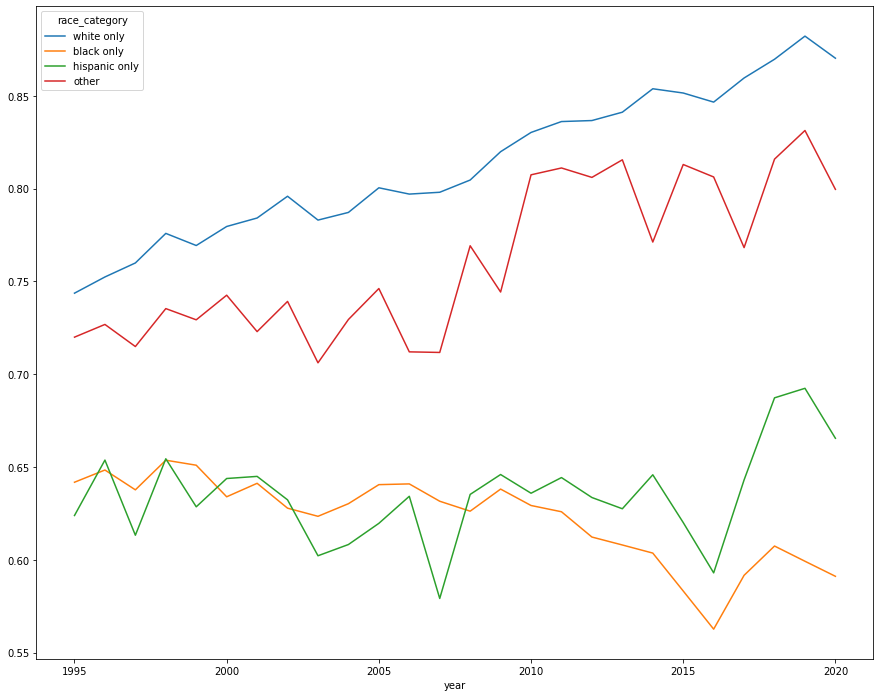

In [12]:
(
    national[["white only", "black only", "hispanic only", "other"]]
    .plot(figsize=(15, 12))
    .get_figure()
    .savefig("output/black_vs_white_national.svg")
)


### Localized Analysis

In [13]:
df = df.merge(
    agencies,
    how="left",
    left_on=["year", "ori_code"],
    right_on=["data_year", "ori"],
)


#### States

In [14]:
state = pd.crosstab(
    index=[df.year, df.state_abbr],
    columns=[df.race_category, df.any_offender_info],
).pipe(get_demo_pcts)

state.to_csv("output/shr_state.csv")

state


race_category    black only  hispanic only  mixed white and black     other  \
year state_abbr                                                               
1995 AK            1.000000            NaN                    NaN  0.600000   
     AL            0.642633            NaN                    NaN  1.000000   
     AR            0.756757       0.500000                    NaN       NaN   
     AZ            0.666667       0.684848                    1.0  0.764706   
     CA            0.562297       0.572534                    0.8  0.643275   
...                     ...            ...                    ...       ...   
2020 VT            0.666667            NaN                    NaN  1.000000   
     WA            0.746479       0.852941                    NaN  0.896552   
     WI            0.704663       0.800000                    0.0  0.923077   
     WV            0.666667            NaN                    0.0  1.000000   
     WY                 NaN       1.000000                    NaN  1.000000   

race_category    two or more races  unknown/no race data  white only  
year state_abbr                                                       
1995 AK                        NaN                   NaN    0.555556  
     AL                        NaN              0.600000    0.661871  
     AR                        NaN                   NaN    0.827273  
     AZ                        NaN              0.000000    0.763033  
     CA                        0.4              0.471429    0.717633  
...                            ...                   ...         ...  
2020 VT                        NaN                   NaN    0.928571  
     WA                        1.0              0.833333    0.915663  
     WI                        1.0              1.000000    0.972028  
     WV                        1.0              0.833333    0.953488  
     WY                        NaN                   NaN    1.000000  

[1298 rows x 7 columns]

In [15]:
state_2020 = state[state.index.get_level_values("year") == 2020]

state_2020.to_csv("output/shr_state_latest.csv")

state_2020


race_category    black only  hispanic only  mixed white and black     other  \
year state_abbr                                                               
2020 AK            1.000000            NaN                    NaN  0.892857   
     AL            0.777778            NaN                    NaN  1.000000   
     AR            0.757895       1.000000               1.000000       NaN   
     AZ            0.726415       0.681529               1.000000  0.758065   
     CA            0.439024       0.510101               0.166667  0.672727   
     CO            0.875000       0.858974               0.750000  0.666667   
     CT            0.554054       0.650000               1.000000       NaN   
     DC            0.497487       0.400000                    NaN       NaN   
     DE            0.593220       0.666667                    NaN       NaN   
     FL            1.000000            NaN                    NaN       NaN   
     FS            1.000000            NaN                    NaN       NaN   
     GA            0.787081       0.869565               0.888889  0.750000   
     HI            1.000000       0.000000                    NaN  0.863636   
     IA            0.745098       0.750000               0.750000  1.000000   
     ID                 NaN       1.000000                    NaN  1.000000   
     IL            0.355670       0.407143               1.000000  0.777778   
     IN            0.530159       0.516129               0.000000  0.666667   
     KS            0.785714       0.857143               1.000000       NaN   
     KY            0.479730       0.666667               0.666667  1.000000   
     LA            0.566372       0.600000               0.666667  0.666667   
     MA            0.492308       0.704545                    NaN  1.000000   
     MD            0.504975       0.769231                    NaN  1.000000   
     ME            0.500000            NaN                    NaN       NaN   
     MI            0.605556       0.833333               1.000000  1.000000   
     MN            0.759259       0.888889                    NaN  0.846154   
     MO            0.571795       0.666667               1.000000  1.000000   
     MS            0.629032       0.000000               1.000000  1.000000   
     MT            1.000000       1.000000                    NaN  0.736842   
     NC            0.713098       0.813953               1.000000  0.608696   
     ND            0.666667       1.000000               1.000000  1.000000   
     NE            0.629630       0.875000                    NaN  1.000000   
     NH            1.000000       1.000000                    NaN       NaN   
     NJ            0.410377       0.607143               1.000000  1.000000   
     NM            0.777778       0.794521               1.000000  0.842105   
     NV            0.646154       0.903226               1.000000  0.900000   
     NY            0.533605       0.611765               0.000000  0.666667   
     OH            0.497053       0.625000               1.000000  1.000000   
     OK            0.876404       0.900000               1.000000  0.857143   
     OR            0.607143       0.714286                    NaN  1.000000   
     PA            0.274038       0.636364                    NaN  0.000000   
     RI            0.333333       0.700000                    NaN       NaN   
     SC            0.772080       0.833333               0.571429  1.000000   
     SD            1.000000       1.000000                    NaN  0.896552   
     TN            0.617284       0.833333               0.250000  0.750000   
     TX            0.785104       0.850539               0.833333  0.826087   
     UT            0.800000       0.909091                    NaN  0.888889   
     VA            0.642012       0.758621               1.000000       NaN   
     VT            0.666667            NaN                    NaN  1.000000   
     WA            0.746479       0.852941        

#### MSAs


In [16]:
msa = pd.crosstab(
    index=[df.year, df.msa_name],
    columns=[df.race_category, df.any_offender_info],
).pipe(get_demo_pcts)

msa.to_csv("output/shr_msa.csv")

msa


race_category                           black only  hispanic only  \
year msa_name                                                       
1995 Abilene, TX                               NaN          1.000   
     Akron, OH                            0.555556            NaN   
     Albany, GA                           0.916667            NaN   
     Albany-Schenectady-Troy, NY          0.666667            NaN   
     Albuquerque, NM                      0.444444            NaN   
...                                            ...            ...   
2020 Yakima, WA                                NaN          0.600   
     York-Hanover, PA                     0.500000            NaN   
     Youngstown-Warren-Boardman, OH-PA    0.454545            NaN   
     Yuba City, CA                             NaN          1.000   
     Yuma, AZ                             0.500000          0.375   

race_category                           mixed white and black  other  \
year msa_name                                                          
1995 Abilene, TX                                          NaN    NaN   
     Akron, OH                                            NaN    1.0   
     Albany, GA                                           1.0    NaN   
     Albany-Schenectady-Troy, NY                          NaN    NaN   
     Albuquerque, NM                                      NaN    0.5   
...                                                       ...    ...   
2020 Yakima, WA                                           NaN    1.0   
     York-Hanover, PA                                     NaN    NaN   
     Youngstown-Warren-Boardman, OH-PA                    NaN    NaN   
     Yuba City, CA                                        NaN    NaN   
     Yuma, AZ                                             NaN    NaN   

race_category                           two or more races  \
year msa_name                                               
1995 Abilene, TX                                      NaN   
     Akron, OH                                        NaN   
     Albany, GA                                       NaN   
     Albany-Schenectady-Troy, NY                      NaN   
     Albuquerque, NM                                  NaN   
...                                                   ...   
2020 Yakima, WA                                       NaN   
     York-Hanover, PA                                 NaN   
     Youngstown-Warren-Boardman, OH-PA                NaN   
     Yuba City, CA                                    NaN   
     Yuma, AZ                                         NaN   

race_category                           unknown/no race data  white only  
year msa_name                                                             
1995 Abilene, TX                                         NaN    1.000000  
     Akron, OH                                           NaN    0.900000  
     Albany, GA                                          NaN    0.500000  
     Albany-Schenectady-Troy, NY                         NaN    0.687500  
     Albuquerque, NM                                     NaN    0.608696  
...                                                      ...         ...  
2020 Yakima, WA                                          NaN    0.733333  
     York-Hanover, PA                                    NaN    1.000000  
     Youngstown-Warren-Boardman, OH-PA                   NaN    0.500000  
     Yuba City, CA                                       NaN    1.000000  
     Yuma, AZ                                            0.5    0.800000  

[8102 rows x 7 columns]

In [17]:
msa_2020 = msa[msa.index.get_level_values("year") == 2020]

msa_2020.to_csv("output/shr_msa_latest.csv")

msa_2020


race_category                           black only  hispanic only  \
year msa_name                                                       
2020 Abilene, TX                          1.000000          1.000   
     Akron, OH                            0.625000            NaN   
     Albany, GA                           0.666667            NaN   
     Albany-Lebanon, OR                        NaN            NaN   
     Albany-Lebanon, OR; Corvallis, OR         NaN            NaN   
...                                            ...            ...   
     Yakima, WA                                NaN          0.600   
     York-Hanover, PA                     0.500000            NaN   
     Youngstown-Warren-Boardman, OH-PA    0.454545            NaN   
     Yuba City, CA                             NaN          1.000   
     Yuma, AZ                             0.500000          0.375   

race_category                           mixed white and black  other  \
year msa_name                                                          
2020 Abilene, TX                                          NaN    NaN   
     Akron, OH                                            NaN    1.0   
     Albany, GA                                           NaN    0.0   
     Albany-Lebanon, OR                                   NaN    NaN   
     Albany-Lebanon, OR; Corvallis, OR                    NaN    NaN   
...                                                       ...    ...   
     Yakima, WA                                           NaN    1.0   
     York-Hanover, PA                                     NaN    NaN   
     Youngstown-Warren-Boardman, OH-PA                    NaN    NaN   
     Yuba City, CA                                        NaN    NaN   
     Yuma, AZ                                             NaN    NaN   

race_category                           two or more races  \
year msa_name                                               
2020 Abilene, TX                                      NaN   
     Akron, OH                                        NaN   
     Albany, GA                                       NaN   
     Albany-Lebanon, OR                               NaN   
     Albany-Lebanon, OR; Corvallis, OR                NaN   
...                                                   ...   
     Yakima, WA                                       NaN   
     York-Hanover, PA                                 NaN   
     Youngstown-Warren-Boardman, OH-PA                NaN   
     Yuba City, CA                                    NaN   
     Yuma, AZ                                         NaN   

race_category                           unknown/no race data  white only  
year msa_name                                                             
2020 Abilene, TX                                         NaN    1.000000  
     Akron, OH                                           NaN    0.950000  
     Albany, GA                                          NaN    1.000000  
     Albany-Lebanon, OR                                  1.0    1.000000  
     Albany-Lebanon, OR; Corvallis, OR                   NaN    1.000000  
...                                                      ...         ...  
     Yakima, WA                                          NaN    0.733333  
     York-Hanover, PA                                    NaN    1.000000  
     Youngstown-Warren-Boardman, OH-PA                   NaN    0.500000  
     Yuba City, CA                                       NaN    1.000000  
     Yuma, AZ                                            0.5    0.800000  

[358 rows x 7 columns]

#### Individual Agencies


In [18]:
agency = (
    pd.crosstab(
        index=[df.year, df.ori_code, df.ucr_agency_name],
        columns=[df.race_category, df.any_offender_info],
    )
    .pipe(get_demo_pcts)
)

agency.to_csv("output/shr_agency.csv")

agency


race_category                                              black only  \
year ori_code  ucr_agency_name                                          
1995 AK0010100 ANCHORAGE                                     1.000000   
     AK0010200 FAIRBANKS                                          NaN   
     AK0014200 UNIV OF AK: FAIRBANKS                              NaN   
     AKASP0000 STATE TROOPERS                                     NaN   
     AL0010000 JEFFERSON                                     0.666667   
...                                                               ...   
2020 WV0090000 DODDRIDGE                                          NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                      1.000000   
     WV0310700 DNR: MONONGALIA COUNTY                             NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                           NaN   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION         NaN   

race_category                                              hispanic only  \
year ori_code  ucr_agency_name                                             
1995 AK0010100 ANCHORAGE                                             NaN   
     AK0010200 FAIRBANKS                                             NaN   
     AK0014200 UNIV OF AK: FAIRBANKS                                 NaN   
     AKASP0000 STATE TROOPERS                                        NaN   
     AL0010000 JEFFERSON                                             NaN   
...                                                                  ...   
2020 WV0090000 DODDRIDGE                                             NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                              NaN   
     WV0310700 DNR: MONONGALIA COUNTY                                NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                              NaN   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION            NaN   

race_category                                              mixed white and black  \
year ori_code  ucr_agency_name                                                     
1995 AK0010100 ANCHORAGE                                                     NaN   
     AK0010200 FAIRBANKS                                                     NaN   
     AK0014200 UNIV OF AK: FAIRBANKS                                         NaN   
     AKASP0000 STATE TROOPERS                                                NaN   
     AL0010000 JEFFERSON                                                     NaN   
...                                                                          ...   
2020 WV0090000 DODDRIDGE                                                     NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                                      NaN   
     WV0310700 DNR: MONONGALIA COUNTY                                        NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                                      NaN   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION                    NaN   

race_category                                                 other  \
year ori_code  ucr_agency_name                                        
1995 AK0010100 ANCHORAGE                                   0.888889   
     AK0010200 FAIRBANKS                                   1.000000   
     AK0014200 UNIV OF AK: FAIRBANKS                            NaN   
     AKASP0000 STATE TROOPERS                              0.222222   
     AL0010000 JEFFERSON                                        NaN   
...                                                             ...   
2020 WV0090000 DODDRIDGE                                        NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                         NaN   
     WV0310700 DNR: MONONGALIA COUNTY                           NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                    1.000000   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION       NaN   

race_category                               

In [19]:
agency_2020 = agency[agency.index.get_level_values("year") == 2020]

agency_2020.to_csv("output/shr_agency_latest.csv")

agency_2020


race_category                                              black only  \
year ori_code  ucr_agency_name                                          
2020 AK0010100 ANCHORAGE                                          1.0   
     AK0010200 FAIRBANKS                                          NaN   
     AL0020600 BAYOU LA BATRE                                     NaN   
     AL0340200 SAMSON                                             NaN   
     AL0460100 TUSKEGEE                                           1.0   
...                                                               ...   
     WV0090000 DODDRIDGE                                          NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                           1.0   
     WV0310700 DNR: MONONGALIA COUNTY                             NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                           NaN   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION         NaN   

race_category                                              hispanic only  \
year ori_code  ucr_agency_name                                             
2020 AK0010100 ANCHORAGE                                             NaN   
     AK0010200 FAIRBANKS                                             NaN   
     AL0020600 BAYOU LA BATRE                                        NaN   
     AL0340200 SAMSON                                                NaN   
     AL0460100 TUSKEGEE                                              NaN   
...                                                                  ...   
     WV0090000 DODDRIDGE                                             NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                              NaN   
     WV0310700 DNR: MONONGALIA COUNTY                                NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                              NaN   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION            NaN   

race_category                                              mixed white and black  \
year ori_code  ucr_agency_name                                                     
2020 AK0010100 ANCHORAGE                                                     NaN   
     AK0010200 FAIRBANKS                                                     NaN   
     AL0020600 BAYOU LA BATRE                                                NaN   
     AL0340200 SAMSON                                                        NaN   
     AL0460100 TUSKEGEE                                                      NaN   
...                                                                          ...   
     WV0090000 DODDRIDGE                                                     NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                                      NaN   
     WV0310700 DNR: MONONGALIA COUNTY                                        NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                                      NaN   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION                    NaN   

race_category                                                 other  \
year ori_code  ucr_agency_name                                        
2020 AK0010100 ANCHORAGE                                   0.777778   
     AK0010200 FAIRBANKS                                   1.000000   
     AL0020600 BAYOU LA BATRE                              1.000000   
     AL0340200 SAMSON                                           NaN   
     AL0460100 TUSKEGEE                                         NaN   
...                                                             ...   
     WV0090000 DODDRIDGE                                        NaN   
     WV0310600 WEST VIRGINIA UNIVERSITY                         NaN   
     WV0310700 DNR: MONONGALIA COUNTY                           NaN   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                    1.000000   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION       NaN   

race_category                               